In [263]:
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn import metrics
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import (
    Ridge,RidgeCV,
    Lasso,LassoCV,
    ElasticNet, ElasticNetCV,
    LinearRegression
)
from sklearn.model_selection import(
    cross_val_score,
    train_test_split
)
from sklearn.preprocessing import (
    StandardScaler,
    PolynomialFeatures
)
from sklearn.feature_selection import SelectFromModel
# pd.set_option('display.max_rows', 1000)  # or 1000
# pd.set_option('display.max_columns', 1000)  # or 1000

from itertools import combinations
from itertools import permutations

from sklearn.preprocessing import OneHotEncoder

### Contents:
- [Data Import](#Data-Import)
- [Pre-processing](#Pre-processing)
- [Model-Selection](#Model-Selection)
- [Model Choice](#Model-Choice)

## Data Import

In [264]:
# read data 

df = pd.read_csv('datasets/temp.csv')
df.drop(columns = ['Unnamed: 0'], inplace = True)

In [265]:
df

,index,id,pid,ms_subclass,ms_zoning,lot_front,lot_area,street,alley,lot_shape,...,enclosed_porch,3ssn_porch,screen_porch,pool_area,misc_val,mo_sold,sale_type,sale_price,gr_liv_area_class,sale_price_classified
0,0,109,533352170,60,RL,69.0552,13517,Pave,NoAlley,IR1,...,0,0,0,0,0,3,WD,130500.0,0,0
1,1,544,531379050,60,RL,43.0000,11492,Pave,NoAlley,IR1,...,0,0,0,0,0,4,WD,220000.0,0,0
2,2,153,535304180,20,RL,68.0000,7922,Pave,NoAlley,Reg,...,0,0,0,0,0,1,WD,109000.0,0,0
3,3,318,916386060,60,RL,73.0000,9802,Pave,NoAlley,Reg,...,0,0,0,0,0,4,WD,174000.0,0,0
4,4,255,906425045,50,RL,82.0000,14235,Pave,NoAlley,IR1,...,0,0,0,0,0,3,WD,138500.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2924,873,1662,527377110,60,RL,80.0000,8000,Pave,NoAlley,Reg,...,0,0,0,0,0,11,WD,NaN,0,0
2925,874,1234,535126140,60,RL,90.0000,14670,Pave,NoAlley,Reg,...,0,0,0,0,0,8,WD,NaN,0,0
2926,875,1373,904100040,20,RL,55.0000,8250,Pave,NoAlley,Reg,...,0,0,0,0,0,8,WD,NaN,0,0
2927,876,1672,527425140,20,RL,60.0000,9000,Pave,NoAlley,Reg,...,0,0,0,0,0,5,WD,NaN,0,0


## Pre-processing 

#### Add weight on ordinal categories 

In [266]:
# declare ordinal category

ordinal_cat = ['lot_shape','util','land_slope','exter_qual','exter_cond','bsmt_qual','bsmt_cond','bsmt_exposure',
               'bsmtfin_type1','bsmt_type2','electrical','kitchen_qual','functional','fireplace_qu','garage_finish',
               'garage_qual','garage_cond','paved_drive','overall_cond','heating_qc'
]

In [267]:
# printing out all unique var in ordinal categories 
for cat in ordinal_cat:
    print(cat,df[cat].unique())

lot_shape ['IR1' 'Reg' 'IR2' 'IR3']
util ['AllPub' 'NoSeWa' 'NoSewr']
land_slope ['Gtl' 'Sev' 'Mod']
exter_qual ['Gd' 'TA' 'Ex' 'Fa']
exter_cond ['TA' 'Gd' 'Fa' 'Ex' 'Po']
bsmt_qual ['TA' 'Gd' 'Fa' 'NoBsmt' 'Ex' 'Po']
bsmt_cond ['TA' 'Gd' 'NoBsmt' 'Fa' 'Po' 'Ex']
bsmt_exposure ['No' 'Gd' 'Av' 'NoBsmt' 'Mn']
bsmtfin_type1 ['GLQ' 'Unf' 'ALQ' 'Rec' 'NoBsmt' 'BLQ' 'LwQ']
bsmt_type2 ['Unf' 'Rec' 'NoBsmt' 'BLQ' 'GLQ' 'LwQ' 'ALQ']
electrical ['SBrkr' 'FuseF' 'FuseA' 'FuseP' 'Mix']
kitchen_qual ['Gd' 'TA' 'Fa' 'Ex' 'Po']
functional ['Typ' 'Mod' 'Min2' 'Maj1' 'Min1' 'Sev' 'Sal' 'Maj2']
fireplace_qu ['NoFireplace' 'TA' 'Gd' 'Po' 'Ex' 'Fa']
garage_finish ['RFn' 'Unf' 'Fin' 'NoGarage']
garage_qual ['TA' 'Fa' 'NoGarage' 'Gd' 'Ex' 'Po']
garage_cond ['TA' 'Fa' 'NoGarage' 'Po' 'Gd' 'Ex']
paved_drive ['Y' 'N' 'P']
overall_cond [8 5 7 6 3 9 2 4 1]
heating_qc ['Ex' 'TA' 'Gd' 'Fa' 'Po']


In [268]:
# defining a function to return rate
def rate_Po_Excellent(col): 
    rate_dict = {'NoBsmt': 0,'NoFireplace': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5,
                 'Gtl':3, 'Sev':1, 'Mod':2,
                'IR1':3, 'Reg':4, 'IR2':2, 'IR3':1,
                'AllPub':3, 'NoSeWa':1, 'NoSewr':2,
                'No':1, 'Gd':4, 'Av':3, 'Mn':2,
                'NoGarage':0, 'Unf': 1, 'RFn': 2, 'Fin': 3,
                'SBrkr':5, 'FuseF':3,'FuseA':4, 'FuseP':2, 'Mix':1,
                'Typ':8, 'Mod':5, 'Min2':6, 'Maj1':4, 'Min1':7, 'Sev':2, 'Sal':1, 'Maj2':3,
                'Y':3, 'N':1, 'P':2,
                 'Unf':1 , 'Rec':3 , 'NoBsmt':0 , 'BLQ':4 , 'GLQ':6 , 'LwQ':2 , 'ALQ':5 ,
                }

    return rate_dict[col]

#### Assign scores to ordinal categories and assign get_dummies for categorical categories

In [269]:
# check if all ranked and sequential 
for cat in ordinal_cat:
    if cat != 'overall_cond':
        df[cat] = df[cat].map(rate_Po_Excellent)
        print(cat,df[cat].unique())
    else:
        print(cat,df[cat].unique())

lot_shape [3 4 2 1]
util [3 1 2]
land_slope [3 2 5]
exter_qual [4 3 5 2]
exter_cond [3 4 2 5 1]
bsmt_qual [3 4 2 0 5 1]
bsmt_cond [3 4 0 2 1 5]
bsmt_exposure [1 4 3 0 2]
bsmtfin_type1 [6 1 5 3 0 4 2]
bsmt_type2 [1 3 0 4 6 2 5]
electrical [5 3 4 2 1]
kitchen_qual [4 3 2 5 1]
functional [8 5 6 4 7 2 1 3]
fireplace_qu [0 3 4 1 5 2]
garage_finish [2 1 3 0]
garage_qual [3 2 0 4 5 1]
garage_cond [3 2 0 1 4 5]
paved_drive [3 1 2]
overall_cond [8 5 7 6 3 9 2 4 1]
heating_qc [5 3 4 2 1]


In [270]:
# Declare main variables consisting from chosen highly correlated variables  

main_variables = ['lot_front', 'lot_area', 'overall_qual', 'age', 'remod_age',
 'exter_qual', 'bsmt_qual', 'heating_qc', 'total_bsmt_sf', '1st_flr_sf', 'gr_liv_area',
 'kitchen_qual', 'garage_finish', 'fireplace_qu',
    'sale_price','garage_area','bsmtfin_sf1','tot_rms_abv_grd' ]

# Declare other columns as categorial features that needs to be dummified.
other_columns = [col for col in df.columns if (col not in main_variables) & (col not in ['index','id','pid']) & (col not in ordinal_cat)]


In [271]:
# to separate categorical and numerical features 
other_cat_features = [col for col in df[other_columns].columns if df[col].dtype == 'O']

other_cat_features

['ms_zoning',
 'street',
 'alley',
 'land_contour',
 'lot_config',
 'neighborhood',
 'cond_1',
 'cond_2',
 'bldg_type',
 'house_style',
 'roof_style',
 'roof_matl',
 'ext_1st',
 'ext_2nd',
 'mas_vnr_type',
 'foundation',
 'heating',
 'central_air',
 'garage_type',
 'sale_type']

**Nominal feature selection**

|Feature|Feature name|Reason for inclusion|
|---|---|---|
|**Neighbourhood**|*neighborhood*|Different neighbourhoods may cost more hence need to consider| 
|**Roof Material**|*roof_matl*|Account for materials of roof| 
|**Condition 1**|*cond_1*|Proximity to main road or railroad needs to be added to account for values that may have impact to price eg. houses near main roads with Bus stops or near train stations will worth more in general| 
|**Condition 2**|*cond_2*|Proximity to main road or railroad needs to be added to account for values that may have impact to price eg. houses near main roads with Bus stops or near train stations will worth more in general| 
|**Building Type**|*bldg_type*|Type of dwelling need to consider as certain houses may cost more/less than the other types| 
|**Sale Type**|*sale_type*|Type of sale is important to consider, for example new home just constructed and sold would probably be eyed by buyers for its general condition assumed to be in top condition| 

In [272]:
# create column for nominal cat selection
col = ['neighborhood', 'roof_matl', 'cond_1', 'cond_2', 'bldg_type', 'sale_type']

norminal_cat = pd.get_dummies(data = df[col], drop_first = True)

In [273]:
# merging two list together, main_variables and ordinal categorical features
col = main_variables.copy()
for iter in ordinal_cat:
    if iter not in col:
        col.append(iter) 

# create df that 
main_data = pd.concat([df[col],norminal_cat], axis = 1)

In [274]:
# writing main_data and combi with other_df

id_adder = df['id']
main_data = pd.concat([id_adder,main_data], axis = 1)

#### Split Test and Train data 

In [275]:
# split test data (Kaggle)
# cross check -->> OK

kaggle_test_final = main_data[2051:]
kaggle_test_final = kaggle_test_final.reset_index(drop = 'index')
kaggle_test_final['sale_price']

0     NaN
1     NaN
2     NaN
3     NaN
4     NaN
       ..
873   NaN
874   NaN
875   NaN
876   NaN
877   NaN
Name: sale_price, Length: 878, dtype: float64

In [276]:
# split train data (Kaggle)

kaggle_train_final = main_data[:2051]
kaggle_train_final['sale_price'].tail(10)

2041    412500.0
2042     83000.0
2043    128000.0
2044    182000.0
2045    394617.0
2046    298751.0
2047     82500.0
2048    177000.0
2049    144000.0
2050    189000.0
Name: sale_price, dtype: float64

#### Apply Standard Scaler to train data

In [277]:
# assign X and y

X = kaggle_train_final.drop(columns = ['sale_price','id'])
y = kaggle_train_final['sale_price']
indices = X.index.values

# Create train/test splits.
X_train, X_test, y_train, y_test,indices_train, indices_test = train_test_split(
    X,
    y,
    indices,
    test_size=0.3,
    random_state = 123
)

# Scale our data.
# Relabeling scaled data as "Z" is common.
sc = StandardScaler()
# Z_train = sc.fit_transform(X_train)
sc.fit(X_train) # fit should only see train data, 
                #else if put in test, will have leak from the train data 
X_train = sc.transform(X_train)
X_test = sc.transform(X_test)

#### Instantiate model

In [278]:
lr = LinearRegression()

In [279]:
lasso = LassoCV(n_alphas=300)

In [280]:
ridge = RidgeCV(alphas=np.logspace(0, 5, 100))

## Model Selection

**Linear regression model**

In [281]:
#fit
lr.fit(X_train,y_train)

# cross val mse
cross_score = - cross_val_score(
    lr,
    X_train,
    y_train,
    cv = 3,
    scoring = 'neg_mean_squared_error'
).mean()

# test mse
mse_test = mean_squared_error(
    y_test,
    lr.predict(X_test)
)
# cross - test 
mse_train_minus_test = cross_score - mse_test

if mse_train_minus_test > 0:
    print(f'MSE for train: {cross_score}')
    print(f'MSE for test: {mse_test}')
    print(f'Underfited by: {mse_train_minus_test}')
else:
    print(f'MSE for train: {cross_score}')
    print(f'MSE for test: {mse_test}')
    print(f'Overfitted by: {mse_train_minus_test}')
print(f'RMSE: {mse_test**0.5}')

MSE for train: 3.1683560524532907e+31
MSE for test: 1.4793934100556615e+30
Underfited by: 3.0204167114477246e+31
RMSE: 1216303173577896.0


**Lasso Regression**

In [282]:
# initiate 
lasso = LassoCV(
    cv=5,
    max_iter=50000,
    n_alphas=200,
)

# Fit model using best ridge alpha!
lasso.fit(X_train, y_train);


lasso.alpha_

319.7476670294984

In [283]:
lasso_best = Lasso(alpha = lasso.alpha_)

In [284]:
# fit lasso best 

lasso_best.fit(X_train,y_train)

Lasso(alpha=319.7476670294984)

In [285]:
# cross val mse
cross_score = - cross_val_score(
    lasso_best,
    X_train,
    y_train,
    cv = 3,
    scoring = 'neg_mean_squared_error'
).mean()

# test mse
mse_test = mean_squared_error(
    y_test,
    lasso_best.predict(X_test)
)
# cross - test 
mse_train_minus_test = cross_score - mse_test

if mse_train_minus_test > 0:
    print(f'MSE for train: {cross_score}')
    print(f'MSE for test: {mse_test}')
    print(f'Underfited by: {mse_train_minus_test}')
else:
    print(f'MSE for train: {cross_score}')
    print(f'MSE for test: {mse_test}')
    print(f'Overfitted by: {mse_train_minus_test}')
print(f'RMSE: {mse_test**0.5}')
print(f'Alpha used: {lasso_best.alpha}')

MSE for train: 853152974.3578879
MSE for test: 1000237797.0542115
Overfitted by: -147084822.69632363
RMSE: 31626.53627974792
Alpha used: 319.7476670294984


**Ridge Regression**

In [286]:
r_alphas = np.logspace(0, 5, 100)
ridge_cv = RidgeCV(alphas=r_alphas, scoring='neg_mean_squared_error', cv=5)
ridge_cv.fit(X_train, y_train);

ridge_best = Ridge(alpha = ridge_cv.alpha_)

ridge_best.fit(X_train,y_train)

# cross val mse
cross_score = - cross_val_score(
    ridge_best,
    X_train,
    y_train,
    cv = 3,
    scoring = 'neg_mean_squared_error'
).mean()

# test mse
mse_test = mean_squared_error(
    y_test,
    ridge_best.predict(X_test)
)
# cross - test 
mse_train_minus_test = cross_score - mse_test

if mse_train_minus_test > 0:
    print(f'MSE for train: {cross_score}')
    print(f'MSE for test: {mse_test}')
    print(f'Underfited by: {mse_train_minus_test}')
else:
    print(f'MSE for train: {cross_score}')
    print(f'MSE for test: {mse_test}')
    print(f'Overfitted by: {mse_train_minus_test}')
print(f'RMSE: {mse_test**0.5}')
print(f'Alpha used: {ridge_cv.alpha_}')

MSE for train: 848683351.5379391
MSE for test: 1006199846.5574503
Overfitted by: -157516495.01951122
RMSE: 31720.653312273538
Alpha used: 73.90722033525779


## Model Choice

Linear regression model did not have a good score due to its high bias and variance due to its complexity after adding many features. Hence Linear regression model will not be used. 

For Lasso and Ridge, the RMSE is fairly competitive, with a RMSE of 31626 and 31743 respectively

Furthermore, both Lasso and Ridge are showing overfitting whereby the RMSE for train set is lower than the test set, hence not being able to generalise to unseen data. 

For this project, I will proceed feature engineering using **Lasso Regression** as I will need to use the model to remove negligible features with zero coefficients. 

**Found outlier and remove**

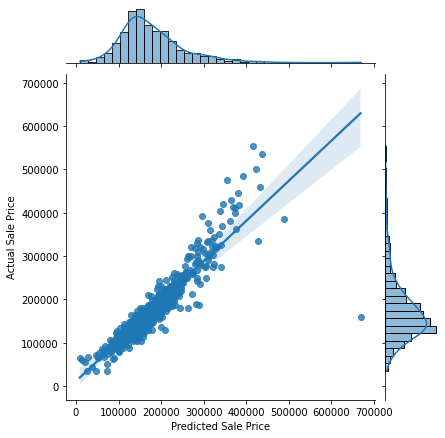

In [287]:
# noticed at higher ends of the sale_price,
# model is calculating below real sales_price

ax = sns.jointplot(
    x = lasso_best.predict(X_test),
    y = y_test,
    kind = 'reg'
)
ax.ax_joint.set_xlabel('Predicted Sale Price')
ax.ax_joint.set_ylabel('Actual Sale Price');

*Comments*

- observed skewing away from prediction model 
- starts from higher end sales price
- model is under predicting housing price 
- Need interaction terms to cater for the combined effect to effectively predict higher end sales price 


In [288]:
# find out index 339 having anomaly 
anomaly = [num for num,val in enumerate (lasso_best.predict(X_test)>500000) if val == True]
anomaly[0]

339

In [289]:
#index with anomoly
indices_test[anomaly[0]]

960

In [290]:
# putting sale price value of the index given

outlier_val = int(main_data.loc[main_data['sale_price'].index == indices_test[anomaly[0]], 'sale_price'].values)

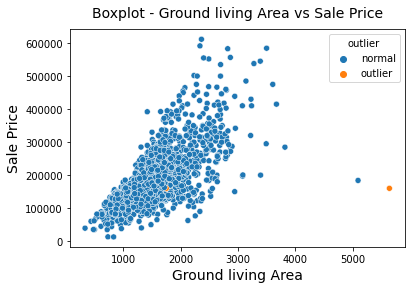

In [291]:
# copy to filter off outlier in scatterplot

filter_outlier = main_data.copy()

filter_outlier['outlier'] = filter_outlier['sale_price'].map(lambda x: 'outlier' if (x == outlier_val) else 'normal')

# found two outliers with one already found 

ax = sns.scatterplot(
    x = 'gr_liv_area',
    y = 'sale_price',
    data = filter_outlier,
    hue = 'outlier'
);

ax.set_title('Boxplot - Ground living Area vs Sale Price', fontdict={'fontsize': 14}, pad = 12)
ax.set_xlabel('Ground living Area', fontdict={'fontsize': 14})
ax.set_ylabel('Sale Price', fontdict={'fontsize': 14});


In [292]:
# found two outliers 
main_data[filter_outlier['gr_liv_area'] > 5000]

,id,lot_front,lot_area,overall_qual,age,remod_age,exter_qual,bsmt_qual,heating_qc,total_bsmt_sf,...,bldg_type_TwnhsE,sale_type_CWD,sale_type_Con,sale_type_ConLD,sale_type_ConLI,sale_type_ConLw,sale_type_New,sale_type_Oth,sale_type_VWD,sale_type_WD
960,1499,313.0,63887,10,0,0,5,5,5,6110.0,...,0,0,0,0,0,0,1,0,0,0
1885,2181,128.0,39290,10,-1,-2,5,5,5,5095.0,...,0,0,0,0,0,0,1,0,0,0


In [293]:
# drop two outliers from train data set 
main_data.drop(index = [960,1885], inplace = True)

**Redo train test split and fit into Lasso Best**

MSE for train: 663227950.1837512
MSE for test: 521823596.87337995
Underfited by: 141404353.31037128
RMSE: 22843.458513836733
Alpha used: 272.9598979802975


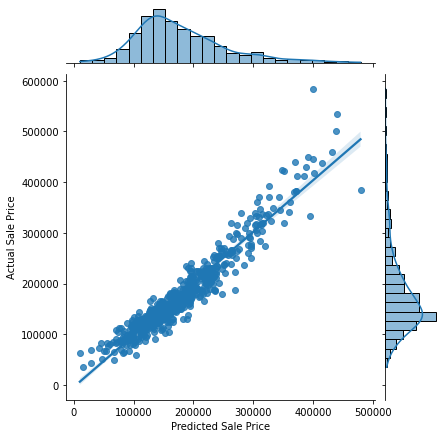

In [294]:
# split test data (Kaggle)
# cross check -->> OK

kaggle_test_final = main_data[2049:]
kaggle_test_final = kaggle_test_final.reset_index(drop = 'index')
kaggle_test_final['sale_price']

# split train data (Kaggle)

kaggle_train_final = main_data[:2049]
kaggle_train_final['sale_price'].tail(10)


# assign X and y

X = kaggle_train_final.drop(columns = ['sale_price','id'])
y = kaggle_train_final['sale_price']
indices = X.index.values

# Create train/test splits.
X_train, X_test, y_train, y_test,indices_train, indices_test = train_test_split(
    X,
    y,
    indices,
    test_size=0.3,
    random_state = 123
)

# Scale our data.
# Relabeling scaled data as "Z" is common.
sc = StandardScaler()
# Z_train = sc.fit_transform(X_train)
sc.fit(X_train) # fit should only see train data, 
                #else if put in test, will have leak from the train data 
X_train = sc.transform(X_train)
X_test = sc.transform(X_test)


# initiate 
lasso = LassoCV(
    cv=5,
    max_iter=50000,
    n_alphas=200,
)

# Fit model using best ridge alpha!
lasso.fit(X_train, y_train);


lasso_best = Lasso(alpha = lasso.alpha_)

# fit lasso best 

lasso_best.fit(X_train,y_train)

# Redo jointplot to check on first pass Lasso model
ax = sns.jointplot(
    x = lasso_best.predict(X_test),
    y = y_test,
    kind = 'reg'
)
ax.ax_joint.set_xlabel('Predicted Sale Price')
ax.ax_joint.set_ylabel('Actual Sale Price');

# cross val mse
cross_score = - cross_val_score(
    lasso_best,
    X_train,
    y_train,
    cv = 3,
    scoring = 'neg_mean_squared_error'
).mean()

# test mse
mse_test = mean_squared_error(
    y_test,
    lasso_best.predict(X_test)
)
# cross - test 
mse_train_minus_test = cross_score - mse_test

if mse_train_minus_test > 0:
    print(f'MSE for train: {cross_score}')
    print(f'MSE for test: {mse_test}')
    print(f'Underfited by: {mse_train_minus_test}')
else:
    print(f'MSE for train: {cross_score}')
    print(f'MSE for test: {mse_test}')
    print(f'Overfitted by: {mse_train_minus_test}')
print(f'RMSE: {mse_test**0.5}')
print(f'Alpha used: {lasso_best.alpha}')

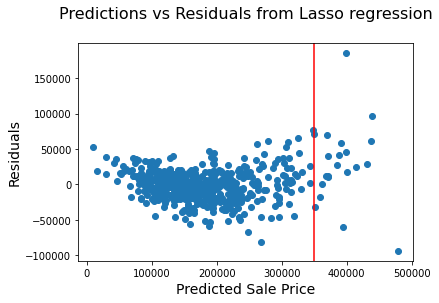

In [295]:
residuals = y_test - lasso_best.predict(X_test)
plt.scatter(lasso_best.predict(X_test), residuals)
plt.xlabel('Predicted Sale Price', fontdict={'fontsize': 14})
plt.ylabel('Residuals', fontdict={'fontsize': 14})
plt.title('Predictions vs Residuals from Lasso regression',  fontdict={'fontsize': 16}, pad = 25)
plt.axvline(x=350000, color = 'red');

In [296]:
# Change in RMSE 

RMSE_before_outlier_removed = 31720
RMSE_after_outlier_removed= 22843

Difference = RMSE_after_outlier_removed - RMSE_before_outlier_removed
percent_dif = round(Difference/RMSE_before_outlier_removed * 100, 2)
print(f'Current RMSE: {RMSE_after_outlier_removed}')
print(f'Difference in RMSE: {Difference}')
print(f'Percentage diff: {percent_dif}%')

Current RMSE: 22843
Difference in RMSE: -8877
Percentage diff: -27.99%


After removing outlier, RMSE improved with Lasso regression by -27.9%


However, we faced problem where the Lasso regression tends to skew upwards away from the linear predicted line.

From the Predictions vs Residuals, we can see after $350K, residuals became larger with delta as close as above $150K

This indicates clear under-evaluation of housing price by the prediction model

**Hypothesis:** ***There is some missing X-factor that dampens the effect of the true value of such grand houses.***

In [298]:
# create data set for feature engineering journal
main_data.to_csv("datasets/For_feature_engineering.csv", index=False)